### Data Download

In [ ]:
# RUN ONLY IF YOU DONT HAVE DATA SET YET

from zipfile import ZipFile
import os
import requests

urls = [
    "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip",
    "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
]

data_dir = "../loppuprojekti/data"
os.makedirs(data_dir, exist_ok=True)

for url in urls:
    filename = os.path.join(data_dir, os.path.basename(url))
    # Download zip file
    print(f"Downloading {url}...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print("Download ready:", filename)
    # Exctract zip file
    print(f"Extracting {filename}...")
    with ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print("Extracted files!")

print("Data pulling ready:", data_dir)

### Data Preparation

In [1]:
import random
import shutil
import os

# For GPU logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

data_dir = "../loppuprojekti/data"
train = "../loppuprojekti/data/DIV2K_train_HR/"
validation = "../loppuprojekti/data/DIV2K_valid_HR/"
test = "../loppuprojekti/data/DIV2K_test_HR"

os.makedirs(test, exist_ok=True)

train_files = os.listdir(train)

num_test_files = int(len(train_files) * 0.15)

files_to_move = random.sample(train_files, num_test_files)

if not os.listdir(test):
    for file in files_to_move:
        src = os.path.join(train, file)
        dst = os.path.join(test, file)
        shutil.move(src, dst)

    print(f"Moved {len(files_to_move)} files to test directory")

else:
    print("Test files already exist")

Test files already exist


In [ ]:
# NOT IN USAGE | tensorflow has this dataset already
'''import os; os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras import ops

AUTOTUNE = tf.data.AUTOTUNE

div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

# Taking train data from div2k_data object
train = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train.cache()
# Validation data
val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()'''

#### Data Augmentation Helper Functions

In [2]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = keras.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return ops.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            ops.flip(lowres_img),
            ops.flip(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = ops.cast(
        keras.random.uniform(shape=(), maxval=4, dtype="float32"), dtype="int32"
    )
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
    """Crop images.

    low resolution images: 24x24
    high resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = ops.shape(lowres_img)[:2]  # (height,width)

    lowres_width = ops.cast(
        keras.random.uniform(
            shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype="float32"
        ),
        dtype="int32",
    )
    lowres_height = ops.cast(
        keras.random.uniform(
            shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype="float32"
        ),
        dtype="int32",
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped

def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

#### Image Augmentation Main Function

In [ ]:
def dataset_object(ds, training=True):
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=4),
        num_parallel_calls=AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds



#### Dataset Creation

In [4]:
import keras
from keras import ops
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE
crop_size = 96
scale = 4



import os

train_dir = os.path.join(data_dir, "DIV2K_train_HR")
val_dir = os.path.join(data_dir, "DIV2K_valid_HR")
test_dir = os.path.join(data_dir, "DIV2K_test_HR")

train_files = [
    os.path.join(train_dir, fname)
    for fname in os.listdir(train_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]

val_files = [
    os.path.join(val_dir, fname)
    for fname in os.listdir(val_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]

test_files = [
    os.path.join(test_dir, fname)
    for fname in os.listdir(test_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]



def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img



def random_crop_and_downscale(hr_img):
    hr_patch = tf.image.random_crop(hr_img, size=[crop_size, crop_size, 3])
    hr_patch.set_shape([crop_size, crop_size, 3])
    lr_patch = tf.image.resize(
        hr_patch, [crop_size // scale, crop_size // scale], method="area"
    )
    lr_patch.set_shape([crop_size // scale, crop_size // scale, 3])
    return lr_patch, hr_patch



# Build datasets


train_ds = tf.data.Dataset.from_tensor_slices(train_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


val_ds = tf.data.Dataset.from_tensor_slices(val_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


test_ds = tf.data.Dataset.from_tensor_slices(test_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


# Apply random cropping and downscaling
BATCH_SIZE = 16

train_sr = train_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.map(random_rotate, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.map(flip_left_right, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_sr = val_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
val_sr = val_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_sr = test_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
test_sr = test_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Example: print shapes

for lr, hr in train_sr.take(1):
    print("LR patch shape:", lr.shape)
    print("HR patch shape:", hr.shape)

2025-04-29 21:55:02.647669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745952902.722528   56556 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745952902.744569   56556 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745952902.897848   56556 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745952902.897875   56556 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745952902.897877   56556 computation_placer.cc:177] computation placer alr

LR patch shape: (16, 24, 24, 3)
HR patch shape: (16, 96, 96, 3)


#### Plot Example of Training Data

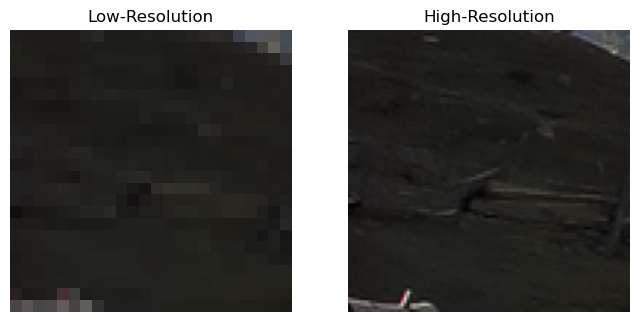

In [5]:
import matplotlib.pyplot as plt

# Get one LR-HR pair from the dataset
for lr, hr in train_sr.take(1):
    lr_img = lr.numpy()
    hr_img = hr.numpy()

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Low-Resolution")
    plt.imshow(lr_img[0])
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("High-Resolution")
    plt.imshow(hr_img[0])
    plt.axis("off")

    plt.show()

#### Utility Functions

In [6]:
# Utilities
def calculate_psnr(original, generated):
    return tf.image.psnr(original, generated, max_val=1.0)


def save_model(model, filepath):
    model.save(filepath)


def load_model(filepath):
    return keras.models.load_model(filepath)

#### Construction of Model

In [11]:
from keras import layers, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      
    factor=0.5,              
    patience=5,              
    min_lr=1e-6,             
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',      # or val_calculate_psnr for PSNR
    patience=20,      
    restore_best_weights=True
)

# Residual block layers
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x

# Up sampling layer
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor**2), 3, padding="same", **kwargs)(inputs)
    x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, block_size=factor))(x)
    x = layers.Conv2D(64 * (factor**2), 3, padding="same", **kwargs)(x)
    x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, block_size=factor))(x)
    return x

# Model creation function
def make_model(num_filters, num_of_residual_blocks):
    input_layer = layers.Input(shape=(None, None, 3))
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x, factor=2)
    x = layers.Conv2D(3, 3, padding="same")(x)


    output_layer = layers.Activation('sigmoid')(x)
    return Model(inputs=input_layer, outputs=output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=16)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=[calculate_psnr])

In [12]:
history = model.fit(train_sr, validation_data=val_sr, epochs=150, callbacks=[early_stop, reduce_lr])
model.save('super_resolution_model.keras')

Epoch 1/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 532ms/step - calculate_psnr: 12.7508 - loss: 0.2193 - val_calculate_psnr: 15.6808 - val_loss: 0.1414 - learning_rate: 1.0000e-04
Epoch 2/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 309ms/step - calculate_psnr: 15.9020 - loss: 0.1335 - val_calculate_psnr: 17.4730 - val_loss: 0.1109 - learning_rate: 1.0000e-04
Epoch 3/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 322ms/step - calculate_psnr: 17.3136 - loss: 0.1146 - val_calculate_psnr: 17.9205 - val_loss: 0.1070 - learning_rate: 1.0000e-04
Epoch 4/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 329ms/step - calculate_psnr: 18.4000 - loss: 0.1025 - val_calculate_psnr: 18.0991 - val_loss: 0.1091 - learning_rate: 1.0000e-04
Epoch 5/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 323ms/step - calculate_psnr: 18.9749 - loss: 0.0976 - val_calculate_psnr: 19.1981 - val_loss: 0.0958 - learning_rate: 1.0000e-04
Epoch 6/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 354ms/step - calculate_psnr: 19.1810 - loss: 0.0976 - val_calculate_psnr: 18.6379 - val_loss: 0.1

In [ ]:
# Load model
loaded_model = load_model('.')

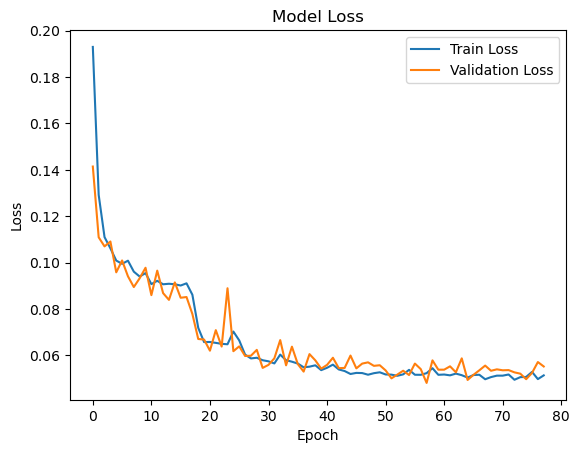

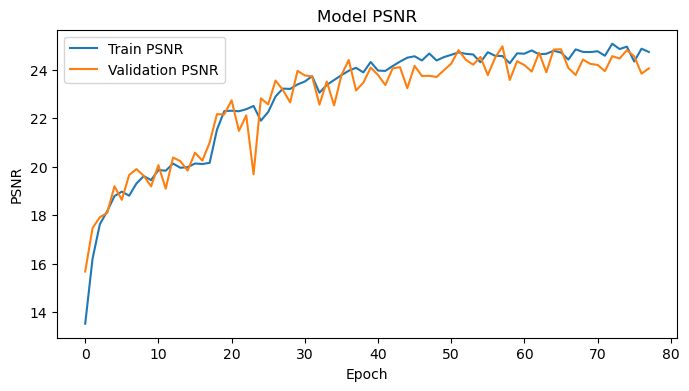

In [13]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Bigger the PSNR value is, more prediction and original high res images are same
plt.figure(figsize=(8, 4))
plt.plot(history.history['calculate_psnr'], label='Train PSNR')
plt.plot(history.history['val_calculate_psnr'], label='Validation PSNR')
plt.title('Model PSNR')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend()

plt.show()

#### Test

Testing model with full size bad quality image

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


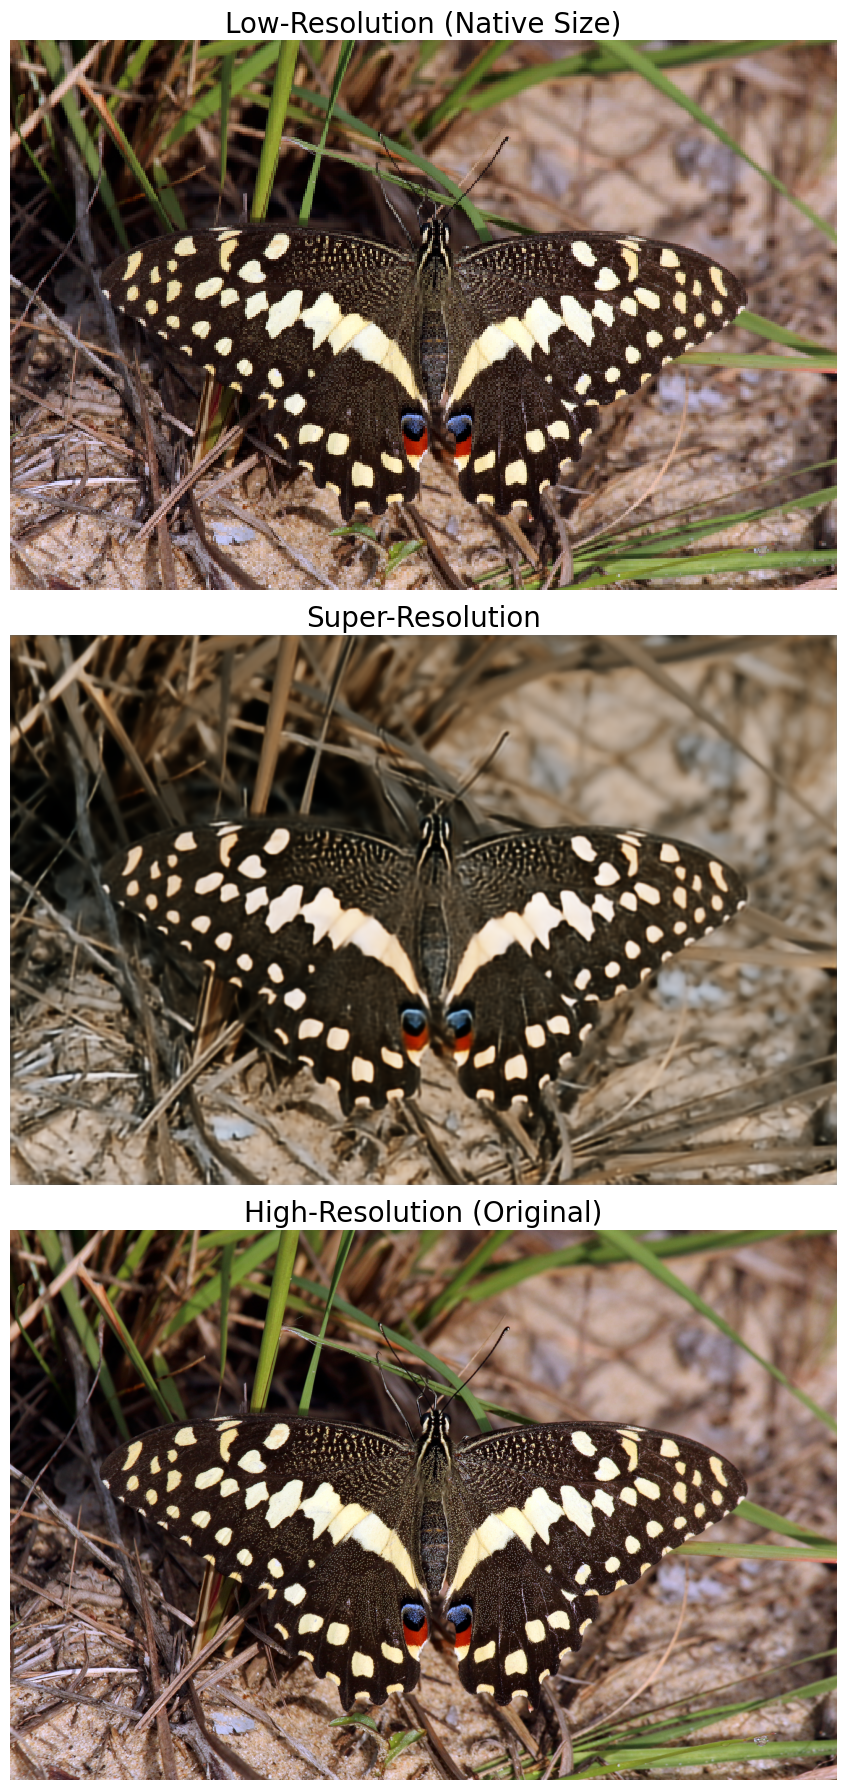

In [14]:
import numpy as np
import matplotlib.pyplot as plt

N = 1  # Index for image to take
for i, hr_img in enumerate(test_ds):
    if i == N:
        hr_img = hr_img.numpy()
        break

scale = 4
h, w = hr_img.shape[0], hr_img.shape[1]
lr_img = tf.image.resize(hr_img, [h // scale, w // scale], method="area")
lr_img_blocky = tf.image.resize(lr_img, [h, w], method="nearest").numpy()

lr_input = tf.expand_dims(lr_img, axis=0)
sr_img = model.predict(lr_input)[0]

# Convert for display
hr_img_disp = np.clip(hr_img * 255, 0, 255).astype("uint8")
sr_img_disp = np.clip(sr_img * 255, 0, 255).astype("uint8")
lr_img_disp = np.clip(lr_img_blocky * 255, 0, 255).astype("uint8")

plt.figure(figsize=(18, 18))

plt.subplot(3, 1, 1)
plt.title("Low-Resolution (Native Size)", fontsize=20)
plt.imshow(np.clip(lr_img.numpy() * 255, 0, 255).astype("uint8"), interpolation='nearest')
plt.axis("off")

plt.subplot(3, 1, 2)
plt.title("Super-Resolution", fontsize=20)
plt.imshow(sr_img_disp)
plt.axis("off")

plt.subplot(3, 1, 3)
plt.title("High-Resolution (Original)", fontsize=20)
plt.imshow(hr_img_disp)
plt.axis("off")

plt.tight_layout()
plt.show()